In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import os
from tqdm import tqdm
import cv2
import numpy as np
import random
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py
import tensorflow as tf
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten,Reshape
from keras.models import Model, Sequential

In [3]:
file = h5py.File('/content/drive/My Drive/695/dataset.hdf5',mode = 'r')

In [4]:
x_train = file['x_train'][:]
y_train = file['y_train'][:]

In [5]:
x_test = file['x_test'][:]
y_test = file['y_test'][:]

In [6]:
x_val = file['x_val'][:]
y_val = file['y_val'][:]

In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_test /= 255
x_val /= 255

In [8]:
x_train = x_train.reshape((-1, 224,224,3))
x_test = x_test.reshape((-1, 224,224,3))
x_val = x_val.reshape((-1,224,224,3))

In [9]:
x_train.shape

(6495, 224, 224, 3)

In [35]:
latent_dims = 256

input_layer = Input(shape=(224,224,3))

## encoding architecture
encode_layer1 = Conv2D(8, kernel_size = (3,3), padding = 'same', activation = 'relu')(input_layer)
encode_layer2 = MaxPooling2D((2,2), padding = 'same')(encode_layer1)
encode_layer3 = Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu')(encode_layer2)
encode_layer4 = MaxPooling2D((2,2), padding = 'same')(encode_layer3)
encode_layer5 = Conv2D(32,kernel_size = (3,3), padding = 'same', activation = 'relu')(encode_layer4)
encode_layer6 = MaxPooling2D((2,2), padding = 'same')(encode_layer5)
encode_layer7 = Conv2D(64,kernel_size = (3,3), padding = 'same', activation = 'relu')(encode_layer6)
encode_layer8 = MaxPooling2D((2,2), padding = 'same')(encode_layer7)

## latent view
latent_view = Flatten()(encode_layer8)
latent_view1 = Dense(latent_dims, activation = 'relu')(latent_view)
latent_view2 = Dense(12544, activation='relu')(latent_view1)
latent_view3 = Reshape((14,14,64))(latent_view2)

## decoding architecture
decode_layer1 = UpSampling2D((2,2))(latent_view3)
decode_layer2 = Conv2D(32, (3,3), padding = 'same', activation='relu')(decode_layer1)
decode_layer3 = UpSampling2D((2,2))(decode_layer2)
decode_layer4 = Conv2D(16, (3,3), padding='same', activation='relu')(decode_layer3)
decode_layer5 = UpSampling2D((2,2))(decode_layer4)
decode_layer6 = Conv2D(8, (3,3), padding='same', activation='relu')(decode_layer5)
decode_layer7 = UpSampling2D((2,2))(decode_layer6)
decode_layer8 = Conv2D(3, (3,3), padding='same', activation='relu')(decode_layer7)

encoder = Model(input_layer,latent_view1)
autoencoder = Model(input_layer,decode_layer8)

In [36]:
encoder.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 224, 224, 8)       224       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 112, 112, 16)      1168      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 56, 56, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 28, 32)       

In [37]:
autoencoder.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 224, 224, 8)       224       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 112, 112, 16)      1168      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 56, 56, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 28, 32)      

In [38]:
autoencoder.compile(optimizer='adam', loss='mse')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/autoencoder_weights.h5",monitor="val_loss",verbose=1,save_best_only=True,
                             save_weights_only=True,)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=128, validation_data=(x_test, x_test), callbacks=[checkpoint, early_stopping])

Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 0.1564
Epoch 00001: val_loss improved from inf to 0.11457, saving model to /content/drive/MyDrive/autoencoder_weights.h5
51/51 [==============================] - 11s 217ms/step - loss: 0.1564 - val_loss: 0.1146
Epoch 2/100
51/51 [==============================] - ETA: 0s - loss: 0.1141
Epoch 00002: val_loss improved from 0.11457 to 0.11266, saving model to /content/drive/MyDrive/autoencoder_weights.h5
51/51 [==============================] - 11s 219ms/step - loss: 0.1141 - val_loss: 0.1127
Epoch 3/100
51/51 [==============================] - ETA: 0s - loss: 0.1119
Epoch 00003: val_loss improved from 0.11266 to 0.11022, saving model to /content/drive/MyDrive/autoencoder_weights.h5
51/51 [==============================] - 11s 214ms/step - loss: 0.1119 - val_loss: 0.1102
Epoch 4/100
51/51 [==============================] - ETA: 0s - loss: 0.1087
Epoch 00004: val_loss improved from 0.11022 to 0.10651, saving model to /con

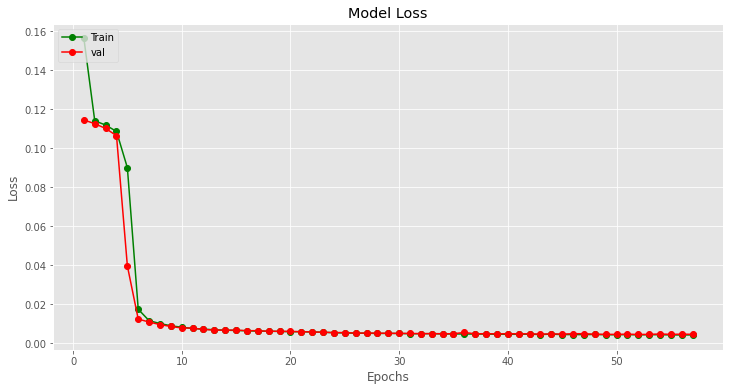

In [39]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,len(history.history['loss'])+1)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

In [40]:
autoencoder.load_weights('/content/drive/MyDrive/autoencoder_weights.h5')

In [41]:
feats_train = encoder.predict(x_train)
feats_val = encoder.predict(x_val)
feats_test = encoder.predict(x_test)
print(feats_train.shape)

(6495, 256)


In [42]:
# using feats from encoder to fit model2
model2 = Sequential()
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint = ModelCheckpoint("/content/drive/MyDrive/autoencoder_weights2_ND_v3.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=True,)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)
history2 = model2.fit(feats_train,y_train, batch_size = 64, epochs = 100,validation_data=(feats_val,y_val),shuffle = True,verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/100
 88/102 [========================>.....] - ETA: 0s - loss: 0.4622 - accuracy: 0.8395
Epoch 00001: val_accuracy improved from -inf to 0.93781, saving model to /content/drive/MyDrive/autoencoder_weights2_ND_v3.h5
102/102 [==============================] - 1s 5ms/step - loss: 0.4288 - accuracy: 0.8519 - val_loss: 0.2044 - val_accuracy: 0.9378
Epoch 2/100
 87/102 [========================>.....] - ETA: 0s - loss: 0.1699 - accuracy: 0.9366
Epoch 00002: val_accuracy improved from 0.93781 to 0.94273, saving model to /content/drive/MyDrive/autoencoder_weights2_ND_v3.h5
102/102 [==============================] - 0s 3ms/step - loss: 0.1664 - accuracy: 0.9381 - val_loss: 0.1449 - val_accuracy: 0.9427
Epoch 3/100
 97/102 [===========================>..] - ETA: 0s - loss: 0.1418 - accuracy: 0.9456
Epoch 00003: val_accuracy improved from 0.94273 to 0.95135, saving model to /content/drive/MyDrive/autoencoder_weights2_ND_v3.h5
102/102 [==============================] - 0s 3ms/step - loss: 

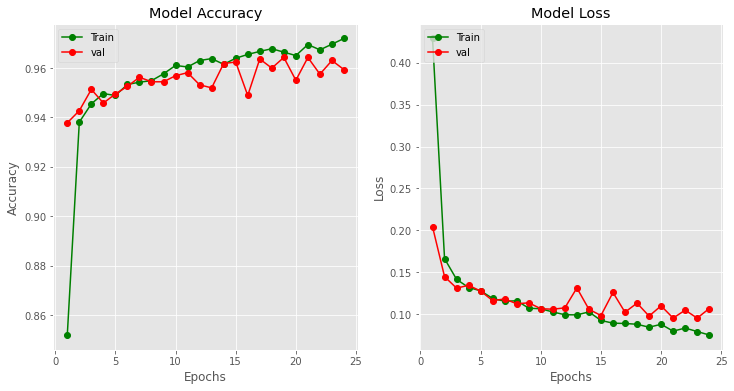

In [43]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,len(history2.history['accuracy'])+1)
plt.subplot(1,2,1)
plt.plot(epochs,history2.history["accuracy"],"go-")
plt.plot(epochs,history2.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history2.history["loss"],"go-")
plt.plot(epochs,history2.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

In [44]:
model2.evaluate(feats_test,y_test)

29/29 [==============================] - 0s 2ms/step - loss: 0.1085 - accuracy: 0.9646


[0.108545683324337, 0.9645625948905945]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


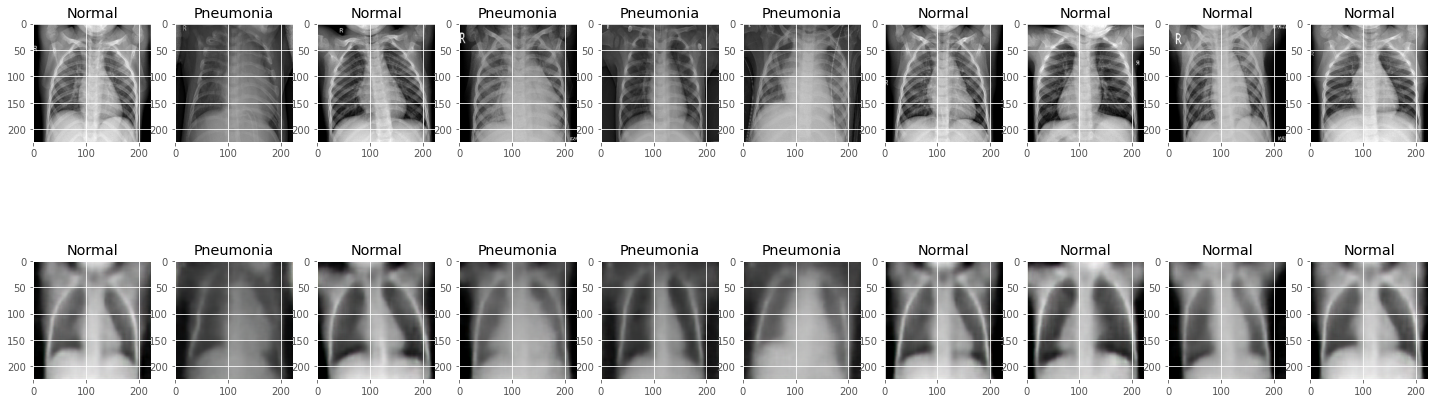

In [59]:
# show some instances
preds = autoencoder.predict(x_test)
plt.figure(figsize = (25,8))
for i in range(10):
  if y_test[i] == 0: label = 'Normal'
  else: label = 'Pneumonia'
  plt.subplot(2,10,i+1)
  plt.imshow(x_test[i])
  plt.title(label)
  plt.subplot(2,10,i+11)
  plt.imshow(preds[i])
  plt.title(label)    

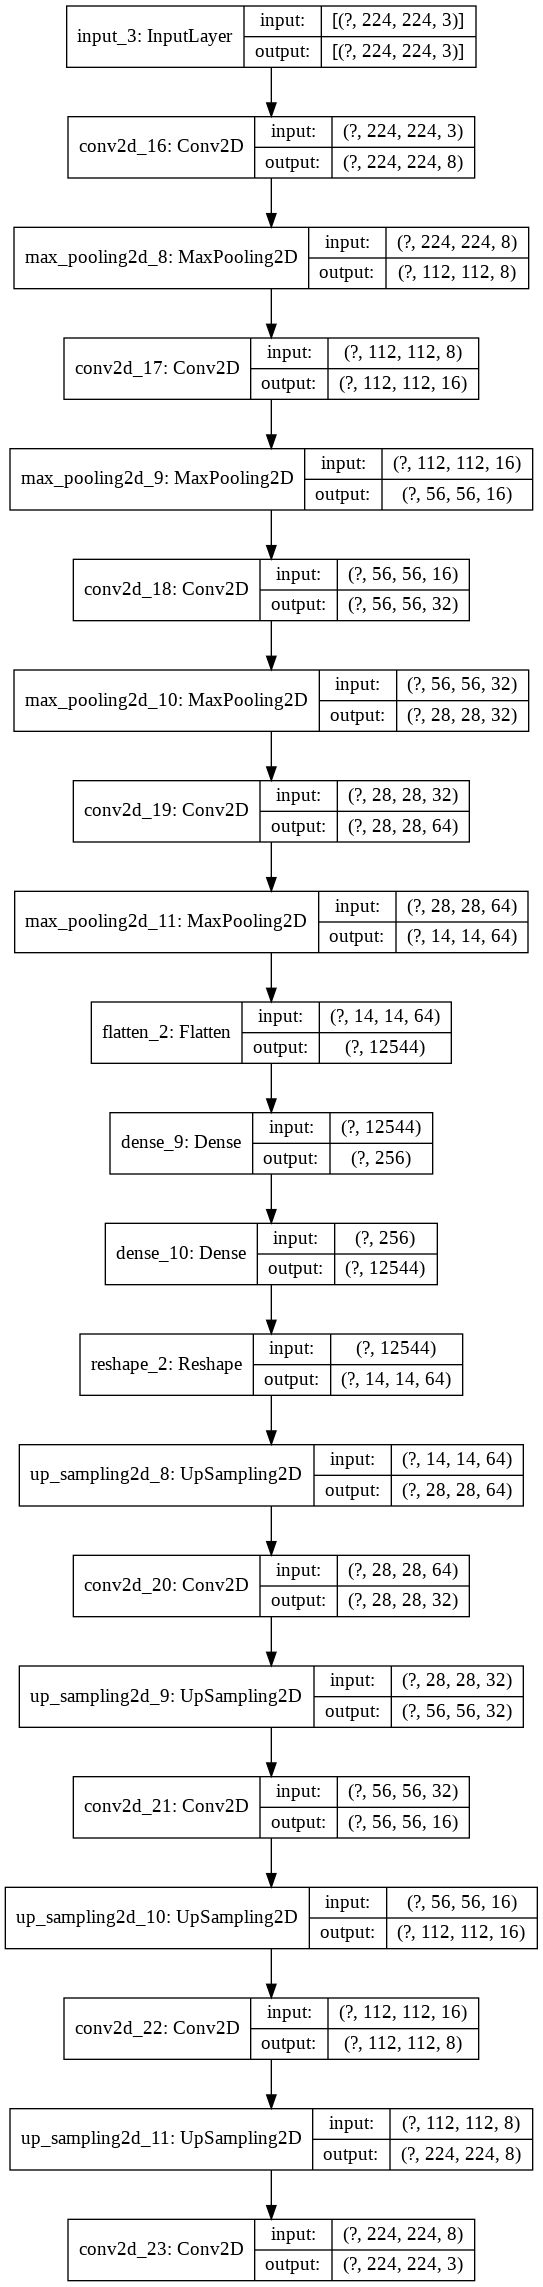

In [45]:
tf.keras.utils.plot_model(autoencoder,show_shapes = True)

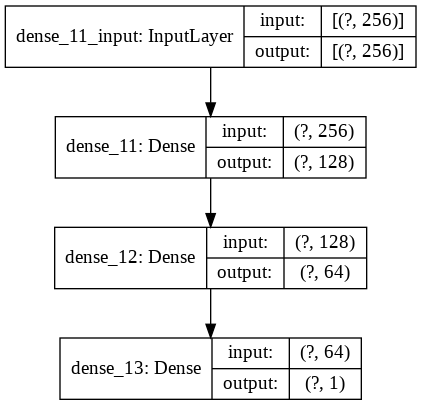

In [46]:
tf.keras.utils.plot_model(model2,show_shapes = True)